In [87]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
# import models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score



One thing to note as begin: I decided to also use a second data set with some additional data for this project. Both are from 538 very similar to each other. This just compliments the 538 more advanced models for evaluating players with more traditional metrics of evaluating players(what df1 will be). Examples of that are 

P/36---how many points does a player average per 36 minutes 

A/36---how many assists a player averages per 36 minutes 

R/36---how many rebounds a player averages per 36 minutes

SB/36---how many combined steals and blocks does a player average per 36 min

TO/36---how many turnovers a player averages per 36 minutes. 

In [88]:


df = pd.read_csv('https://raw.githubusercontent.com/fivethirtyeight/data/master/nba-raptor/historical_RAPTOR_by_player.csv')

df1 = pd.read_csv('https://raw.githubusercontent.com/fivethirtyeight/nba-player-advanced-metrics/master/nba-data-historical.csv')

df.head()

df1.head(100)

,player_id,name_common,year_id,type,age,team_id,pos,tmRtg,franch_id,G,Min,MP%,MPG,P/36,TS%,A/36,R/36,SB/36,TO/36,Raptor O,Raptor D,Raptor+/-,Raptor WAR,PIE%,AWS%,USG%,AST%,TOV%,ORB%,DRB%,TRB%,STL%,BLK%,ORtg,%Pos,DRtg,2P%,3P%,FT%,3PAr,FTAr,Pace +/-
0,youngtr01,Trae Young,2020,RS,21,ATL,PG,NaN,ATL,60,2120,NaN,35.3,NaN,59.5,NaN,NaN,NaN,NaN,7.1,-3.3,3.7,7.19,NaN,NaN,34.9,45.6,16.2,1.6,11.5,6.5,1.4,0.3,NaN,NaN,NaN,NaN,NaN,NaN,45.5,44.8,2.9
1,huntede01,De'Andre Hunter,2020,RS,22,ATL,SF,NaN,ATL,63,2018,NaN,32.0,NaN,52.1,NaN,NaN,NaN,NaN,-2.5,-1.3,-3.8,-1.09,NaN,NaN,17.5,8.0,12.1,2.3,13.1,7.6,1.0,0.7,NaN,NaN,NaN,NaN,NaN,NaN,44.5,21.1,0.0
2,huertke01,Kevin Huerter,2020,RS,21,ATL,SG,NaN,ATL,56,1760,NaN,31.4,NaN,53.6,NaN,NaN,NaN,NaN,-0.4,-2.4,-2.8,-0.05,NaN,NaN,17.1,17.5,12.0,2.1,12.0,7.0,1.4,1.3,NaN,NaN,NaN,NaN,NaN,NaN,54.8,10.5,0.1
3,reddica01,Cam Reddish,2020,RS,20,ATL,SF,NaN,ATL,58,1551,NaN,26.7,NaN,50.0,NaN,NaN,NaN,NaN,-2.9,0.0,-3.0,-0.18,NaN,NaN,18.9,8.0,13.6,2.4,12.7,7.5,1.9,1.5,NaN,NaN,NaN,NaN,NaN,NaN,45.1,22.7,0.9
4,collijo01,John Collins,2020,RS,22,ATL,PF,NaN,ATL,41,1363,NaN,33.2,NaN,65.9,NaN,NaN,NaN,NaN,0.0,-0.4,-0.4,1.65,NaN,NaN,22.7,7.6,10.1,9.0,24.0,16.4,1.1,4.1,NaN,NaN,NaN,NaN,NaN,NaN,24.3,24.8,0.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,washipj01,P.J. Washington,2020,RS,21,CHA,PF,NaN,CHA,58,1759,NaN,30.3,NaN,54.7,NaN,NaN,NaN,NaN,-2.4,-0.7,-3.1,-0.30,NaN,NaN,18.6,11.3,12.5,3.5,16.6,9.8,1.5,2.3,NaN,NaN,NaN,NaN,NaN,NaN,39.0,23.1,0.1
96,zelleco01,Cody Zeller,2020,RS,27,CHA,C,NaN,CHA,58,1341,NaN,23.1,NaN,57.6,NaN,NaN,NaN,NaN,-0.4,-1.3,-1.7,0.75,NaN,NaN,20.8,11.3,11.9,12.6,21.2,16.7,1.5,1.7,NaN,NaN,NaN,NaN,NaN,NaN,15.7,37.4,-0.1
97,monkma01,Malik Monk,2020,RS,21,CHA,SG,NaN,CHA,55,1169,NaN,21.3,NaN,53.0,NaN,NaN,NaN,NaN,-1.6,-2.9,-4.5,-1.02,NaN,NaN,22.9,16.6,12.6,2.4,12.6,7.3,1.1,1.3,NaN,NaN,NaN,NaN,NaN,NaN,41.8,20.5,0.3
98,biyombi01,Bismack Biyombo,2020,RS,27,CHA,C,NaN,CHA,53,1029,NaN,19.4,NaN,57.0,NaN,NaN,NaN,NaN,-2.2,-0.8,-3.1,-0.16,NaN,NaN,16.8,7.8,12.2,12.3,20.7,16.3,0.5,4.4,NaN,NaN,NaN,NaN,NaN,NaN,0.0,54.3,-0.8


This was probably the most important decision I made. I got rid of any small sample sizes so any player who played less than 250 minutes in a particular season. The reason for this is that traditionally NBA players need at least 15-20 worth of games to have sample sizes that are big enough that hte stats can begin to stabilize. Otherwise it is just too noisy and a byproduct of variance more than anything that should be meaningfully charted or measured. 

The other decision I made was to exclude any seasons prior to 2000. A few reasons I did this. First of all it just makes it easier there are as is already about 10000 rows of data even making this filter. Secondly alot of the data they use in designing these 538 basketball algorithms is not nearly as reliable pre 2000. Tracking cameras didnt really exist back then to nearly the same degree they do now. Stat keepers werent as reliable and consistent. There was no source of verifying alot of the data and hence it can lead to some questionable figures. All these basic stats you see like points, rebounds, assists, shooting percentage etc are incorporated in these 538 models Im using so the accuracy of those historical records absolutely matters in determining the accuracy and validity of these models. It's best hence in my opinion to just leave them out we have more than enough data to work with without them still.

In [89]:
df1.drop(df1[df1.Min < 250].index, inplace=True)
df1.drop(df1[df1.year_id < 2000].index, inplace=True)

In [90]:
df1.drop(['player_id', 'franch_id', 'PIE%', 'AWS%', 'ORtg', 'DRtg', 'MP%'], axis=1)

,name_common,year_id,type,age,team_id,pos,tmRtg,G,Min,MPG,P/36,TS%,A/36,R/36,SB/36,TO/36,Raptor O,Raptor D,Raptor+/-,Raptor WAR,USG%,AST%,TOV%,ORB%,DRB%,TRB%,STL%,BLK%,%Pos,2P%,3P%,FT%,3PAr,FTAr,Pace +/-
0,Trae Young,2020,RS,21,ATL,PG,NaN,60,2120,35.3,NaN,59.5,NaN,NaN,NaN,NaN,7.1,-3.3,3.7,7.19,34.9,45.6,16.2,1.6,11.5,6.5,1.4,0.3,NaN,NaN,NaN,NaN,45.5,44.8,2.9
1,De'Andre Hunter,2020,RS,22,ATL,SF,NaN,63,2018,32.0,NaN,52.1,NaN,NaN,NaN,NaN,-2.5,-1.3,-3.8,-1.09,17.5,8.0,12.1,2.3,13.1,7.6,1.0,0.7,NaN,NaN,NaN,NaN,44.5,21.1,0.0
2,Kevin Huerter,2020,RS,21,ATL,SG,NaN,56,1760,31.4,NaN,53.6,NaN,NaN,NaN,NaN,-0.4,-2.4,-2.8,-0.05,17.1,17.5,12.0,2.1,12.0,7.0,1.4,1.3,NaN,NaN,NaN,NaN,54.8,10.5,0.1
3,Cam Reddish,2020,RS,20,ATL,SF,NaN,58,1551,26.7,NaN,50.0,NaN,NaN,NaN,NaN,-2.9,0.0,-3.0,-0.18,18.9,8.0,13.6,2.4,12.7,7.5,1.9,1.5,NaN,NaN,NaN,NaN,45.1,22.7,0.9
4,John Collins,2020,RS,22,ATL,PF,NaN,41,1363,33.2,NaN,65.9,NaN,NaN,NaN,NaN,0.0,-0.4,-0.4,1.65,22.7,7.6,10.1,9.0,24.0,16.4,1.1,4.1,NaN,NaN,NaN,NaN,24.3,24.8,0.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15257,Richard Hamilton,2000,RS,21,WAS,SG,-3.5,71,1373,19.3,18.1,48.2,3.1,3.6,1.0,2.4,-1.5,-2.6,-4.1,-0.97,24.2,13.7,11.2,3.1,7.7,5.4,1.1,0.3,22.8,42.8,36.4,77.4,12.7,22.0,0.2
15258,Isaac Austin,2000,RS,30,WAS,C,-3.5,59,1173,19.9,13.1,48.1,2.4,9.3,1.8,3.5,-5.2,-1.3,-6.5,-2.26,19.6,10.0,20.6,6.2,21.7,13.8,0.8,2.3,19.8,43.1,25.0,68.6,1.1,38.9,0.0
15259,Michael Smith,2000,RS,27,WAS,SF,-3.5,46,1145,24.9,9.8,61.1,1.9,11.2,1.7,1.5,1.5,-0.1,1.4,2.42,10.9,7.3,16.0,12.0,21.4,16.6,1.2,1.4,12.1,56.5,0.0,72.3,0.5,52.6,-0.4
15260,Gerard King,2000,RS,27,WAS,SF,-3.5,62,1060,17.1,12.0,53.4,1.8,9.2,1.8,1.5,-0.2,-0.1,-0.2,1.36,14.5,7.4,11.8,9.0,18.2,13.6,1.7,1.0,14.6,50.2,0.0,74.2,0.0,23.8,0.0


A subjective decision I had to make is that even amongst the players from only 2000 onwards about 5-10% of them had some kind of null values in the following rows. There is no way of reasonably being able to estimate what the figures were. What I decided to do was just not use any players who had null values in these rows. As is, the sample size will still be plenty there is still more than enough(thousands of players) to run models on. A substantial % of the null values are from the year 2020(all players in 2020 had some null values) so another way of looking at this project is its analyzing basketball data from 2000-2019 instead of 2000-2020. 

In [91]:
df1 = df1[df1['P/36'].notna()]
df1 = df1[df1['A/36'].notna()]
df1 = df1[df1['R/36'].notna()]
df1 = df1[df1['SB/36'].notna()]
df1 = df1[df1['TO/36'].notna()]
df1 = df1[df1['%Pos'].notna()]
df1 = df1[df1['2P%'].notna()]
df1 = df1[df1['3P%'].notna()]

In [92]:
df1.head()

,player_id,name_common,year_id,type,age,team_id,pos,tmRtg,franch_id,G,Min,MP%,MPG,P/36,TS%,A/36,R/36,SB/36,TO/36,Raptor O,Raptor D,Raptor+/-,Raptor WAR,PIE%,AWS%,USG%,AST%,TOV%,ORB%,DRB%,TRB%,STL%,BLK%,ORtg,%Pos,DRtg,2P%,3P%,FT%,3PAr,FTAr,Pace +/-
808,youngtr01,Trae Young,2019,RS,20,ATL,PG,-5.7,ATL,81,2503,63.0,30.9,21.4,53.9,9.0,4.2,1.2,4.3,2.4,-4.5,-2.1,0.82,12.5,10.2,28.4,40.5,17.6,2.6,10.2,6.3,1.3,0.5,107.4,29.8,116.8,47.7,32.4,82.9,38.4,33.0,1.8
809,huertke01,Kevin Huerter,2019,RS,20,ATL,SG,-5.7,ATL,75,2048,51.6,27.3,12.3,53.3,3.6,4.1,1.5,1.8,0.4,-2.2,-1.8,1.04,6.7,6.9,15.7,14.5,13.8,3.0,9.7,6.3,1.5,1.1,105.5,15.7,116.2,45.7,38.5,73.2,53.7,8.5,0.6
810,bembrde01,DeAndre' Bembry,2019,RS,24,ATL,SG,-5.7,ATL,82,1931,48.6,23.5,12.3,50.8,3.6,6.4,2.6,2.5,-3.2,1.1,-2.1,0.66,7.8,6.6,17.2,14.7,17.4,2.9,16.9,9.7,2.5,1.8,97.2,17.4,111.5,50.8,28.9,64.0,28.1,22.1,0.6
811,collijo01,John Collins,2019,RS,21,ATL,PF,-5.7,ATL,61,1829,46.1,30.0,22.5,62.7,2.3,11.3,1.2,2.3,3.2,-0.5,2.7,5.13,14.3,14.9,23.7,11.0,11.2,12.3,22.1,17.1,0.6,1.8,121.7,23.3,114.6,60.9,34.8,76.3,19.0,32.0,0.2
812,bazemke01,Kent Bazemore,2019,RS,29,ATL,SG,-5.7,ATL,67,1643,41.4,24.5,16.4,50.7,3.2,5.5,2.8,2.6,-2.9,0.6,-2.3,0.39,7.8,6.9,22.0,13.5,13.6,2.3,14.6,8.3,2.5,2.2,98.1,21.3,111.8,46.5,32.0,72.6,43.4,25.3,1.6


In [93]:
df1.dtypes

player_id       object
name_common     object
year_id          int64
type            object
age              int64
team_id         object
pos             object
tmRtg          float64
franch_id       object
G                int64
Min              int64
MP%            float64
MPG            float64
P/36           float64
TS%            float64
A/36           float64
R/36           float64
SB/36          float64
TO/36          float64
Raptor O       float64
Raptor D       float64
Raptor+/-      float64
Raptor WAR     float64
PIE%           float64
AWS%           float64
USG%           float64
AST%           float64
TOV%           float64
ORB%           float64
DRB%           float64
TRB%           float64
STL%           float64
BLK%           float64
ORtg           float64
%Pos           float64
DRtg           float64
2P%            float64
3P%            float64
FT%            float64
3PAr           float64
FTAr           float64
Pace +/-       float64
dtype: object

This is also important: positions in the data base are listed as teh following: PG, SG, SF, PF, C

PG--point guard

SG--shooting guard

SF---small forward

PF--power forward

C--center

Traditionally in basketball these positions are also given numbers. 1 for PG, 2 for SG, 3 for SF, 4 for PF, 5 for C. I essentially one hot encoded these variables in this data set. That is I turned what is listed under position as PG into 1, 2 for SG, 3 for SF etc. This will matter later on when I do some logistic regression to try to see if these models can accurately predict what position a player plays and some K Means data.

In [94]:
df1['pos'] = df1['pos'].map({'PG': 1, 'SG': 2, 'SF': 3, 'PF': 4, 'C': 5})

And here is the other data set Im referring to as well. 

In [95]:
df1.head()

,player_id,name_common,year_id,type,age,team_id,pos,tmRtg,franch_id,G,Min,MP%,MPG,P/36,TS%,A/36,R/36,SB/36,TO/36,Raptor O,Raptor D,Raptor+/-,Raptor WAR,PIE%,AWS%,USG%,AST%,TOV%,ORB%,DRB%,TRB%,STL%,BLK%,ORtg,%Pos,DRtg,2P%,3P%,FT%,3PAr,FTAr,Pace +/-
808,youngtr01,Trae Young,2019,RS,20,ATL,1,-5.7,ATL,81,2503,63.0,30.9,21.4,53.9,9.0,4.2,1.2,4.3,2.4,-4.5,-2.1,0.82,12.5,10.2,28.4,40.5,17.6,2.6,10.2,6.3,1.3,0.5,107.4,29.8,116.8,47.7,32.4,82.9,38.4,33.0,1.8
809,huertke01,Kevin Huerter,2019,RS,20,ATL,2,-5.7,ATL,75,2048,51.6,27.3,12.3,53.3,3.6,4.1,1.5,1.8,0.4,-2.2,-1.8,1.04,6.7,6.9,15.7,14.5,13.8,3.0,9.7,6.3,1.5,1.1,105.5,15.7,116.2,45.7,38.5,73.2,53.7,8.5,0.6
810,bembrde01,DeAndre' Bembry,2019,RS,24,ATL,2,-5.7,ATL,82,1931,48.6,23.5,12.3,50.8,3.6,6.4,2.6,2.5,-3.2,1.1,-2.1,0.66,7.8,6.6,17.2,14.7,17.4,2.9,16.9,9.7,2.5,1.8,97.2,17.4,111.5,50.8,28.9,64.0,28.1,22.1,0.6
811,collijo01,John Collins,2019,RS,21,ATL,4,-5.7,ATL,61,1829,46.1,30.0,22.5,62.7,2.3,11.3,1.2,2.3,3.2,-0.5,2.7,5.13,14.3,14.9,23.7,11.0,11.2,12.3,22.1,17.1,0.6,1.8,121.7,23.3,114.6,60.9,34.8,76.3,19.0,32.0,0.2
812,bazemke01,Kent Bazemore,2019,RS,29,ATL,2,-5.7,ATL,67,1643,41.4,24.5,16.4,50.7,3.2,5.5,2.8,2.6,-2.9,0.6,-2.3,0.39,7.8,6.9,22.0,13.5,13.6,2.3,14.6,8.3,2.5,2.2,98.1,21.3,111.8,46.5,32.0,72.6,43.4,25.3,1.6


In [ ]:
check for null values. 

In [96]:
df1.isnull().sum()


player_id      0
name_common    0
year_id        0
type           0
age            0
team_id        0
pos            0
tmRtg          0
franch_id      0
G              0
Min            0
MP%            0
MPG            0
P/36           0
TS%            0
A/36           0
R/36           0
SB/36          0
TO/36          0
Raptor O       0
Raptor D       0
Raptor+/-      0
Raptor WAR     0
PIE%           0
AWS%           0
USG%           0
AST%           0
TOV%           0
ORB%           0
DRB%           0
TRB%           0
STL%           0
BLK%           0
ORtg           0
%Pos           0
DRtg           0
2P%            0
3P%            0
FT%            0
3PAr           0
FTAr           0
Pace +/-       0
dtype: int64

Project 2 - Part 2 (Core)
Using the approved dataset you proposed for project 2 part 1 last week, you will clean and explore the data set.  

To meet the requirements for this week you must have:

-deleted unnecessary columns

-deleted duplicate rows

-identified and addressed missing values 

-identified and corrected inconsistencies in data for categorical values (i.e. Cat, cat, cats)

-produced univariate visuals for the target and all features

-identified outliers

-produce a correlation heatmap and identify any moderate or strong correlations between your target and your features and/or between one feature and another

In [97]:
# Check for duplicates
df.duplicated().any()

False

In [98]:
# Check for missings
df.isnull().sum()

player_name         0
player_id           0
season              0
poss                0
mp                  0
raptor_offense      0
raptor_defense      0
raptor_total        0
war_total           0
war_reg_season      0
war_playoffs        0
predator_offense    0
predator_defense    0
predator_total      0
pace_impact         1
dtype: int64

In [99]:
# There are missing values in the Region column - let's investigate those
df[df['pace_impact'].isnull()]

,player_name,player_id,season,poss,mp,raptor_offense,raptor_defense,raptor_total,war_total,war_reg_season,war_playoffs,predator_offense,predator_defense,predator_total,pace_impact
12254,Malik Newman,newmama01,2020,8,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN


In [100]:
df = df.drop(index = 12254)

In [101]:
df.drop(df[df.mp < 250].index, inplace=True)
df.drop(df[df.season < 2000].index, inplace=True)
df.drop(df[df.war_playoffs == 0.0000000].index, inplace=True)

Note I dropped the same values for this data set as the last one. That is I got rid of any small sample sizes so any player who played less than 250 minutes in a particular season. The reason for this is that traditionally NBA players need at least 15-20 worth of games to have sample sizes that are big enough that hte stats can begin to stabilize. Otherwise it is just too noisy and a byproduct of variance more than anything that should be meaningfully charted or measured. 
The other decision I made was to exclude any seasons prior to 2000. Same reasons for doing so as stated earlier for that data set. 

In [102]:
df.head()

,player_name,player_id,season,poss,mp,raptor_offense,raptor_defense,raptor_total,war_total,war_reg_season,war_playoffs,predator_offense,predator_defense,predator_total,pace_impact
32,Tariq Abdul-Wahad,abdulta01,2003,553,283,-0.212466,-0.957466,-1.169932,0.228929,0.199733,0.029195,-0.861448,-1.391198,-2.252645,-0.325525
44,Shareef Abdur-Rahim,abdursh01,2006,4037,2090,0.760258,-0.260694,0.499564,3.435711,3.638852,-0.203141,0.467694,-0.220544,0.247150,0.073112
52,Alex Abrines,abrinal01,2017,2387,1135,0.543421,-1.144832,-0.601411,1.249008,1.447708,-0.198700,0.077102,-1.038677,-0.961575,0.326413
53,Alex Abrines,abrinal01,2018,2546,1244,-0.020826,-1.502642,-1.523468,0.777304,0.465912,0.311392,-0.174621,-1.112625,-1.287247,-0.456141
55,Precious Achiuwa,achiupr01,2021,1581,749,-4.347596,0.954821,-3.392775,-0.246055,-0.246776,0.000721,-3.817713,0.474828,-3.342885,0.329157


In [104]:
df.dtypes

player_name          object
player_id            object
season                int64
poss                  int64
mp                    int64
raptor_offense      float64
raptor_defense      float64
raptor_total        float64
war_total           float64
war_reg_season      float64
war_playoffs        float64
predator_offense    float64
predator_defense    float64
predator_total      float64
pace_impact         float64
dtype: object

In [105]:
df.describe()

,season,poss,mp,raptor_offense,raptor_defense,raptor_total,war_total,war_reg_season,war_playoffs,predator_offense,predator_defense,predator_total,pace_impact
count,4094.000000,4094.000000,4094.000000,4094.000000,4094.000000,4094.000000,4094.000000,4094.000000,4094.000000,4094.000000,4094.000000,4094.000000,4094.000000
mean,2010.743771,3564.646556,1813.323156,-0.234209,0.237644,0.003435,3.493236,3.013916,0.479321,-0.220412,0.139142,-0.081271,0.051637
std,6.344076,1814.836061,930.789623,2.443971,1.698242,3.045513,4.270257,3.640942,0.895517,2.455723,1.757205,3.240760,0.591933
min,2000.000000,470.000000,251.000000,-8.490284,-7.088720,-14.568172,-5.148741,-5.252562,-1.376520,-8.240138,-6.609847,-13.598980,-2.328584
25%,2005.000000,2013.000000,1019.500000,-1.845632,-0.912044,-2.032223,0.390124,0.342548,-0.022344,-1.886360,-1.055829,-2.269006,-0.326718
50%,2011.000000,3515.000000,1788.500000,-0.332013,0.136188,-0.089696,2.179884,1.943782,0.158071,-0.381169,0.083077,-0.192514,0.011477
75%,2016.000000,4996.250000,2544.750000,1.083125,1.306193,1.842282,5.303889,4.670808,0.666297,1.161081,1.277425,1.915769,0.375670
max,2021.000000,8238.000000,4202.000000,10.379411,7.907439,12.580815,28.525259,23.659318,7.006934,10.893131,7.459246,13.347925,3.996917


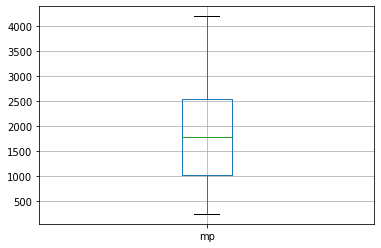

In [106]:
df.boxplot(column = 'mp');

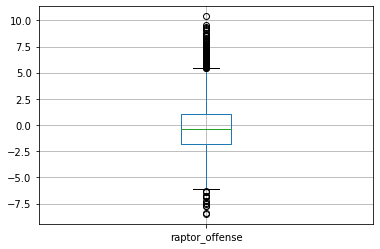

In [107]:
df.boxplot(column = 'raptor_offense');

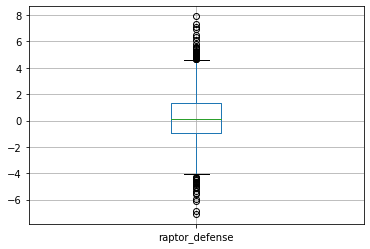

In [108]:
df.boxplot(column = 'raptor_defense');

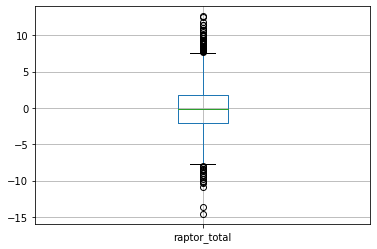

In [109]:
df.boxplot(column = 'raptor_total');

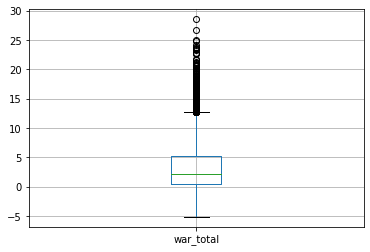

In [110]:
df.boxplot(column = 'war_total');

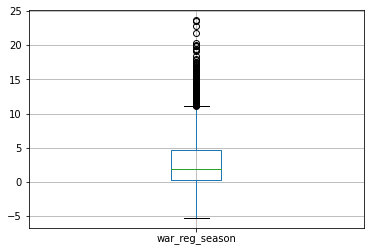

In [111]:
df.boxplot(column = 'war_reg_season');

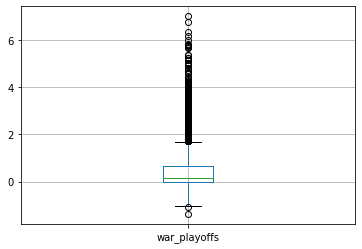

In [112]:
df.boxplot(column = 'war_playoffs');

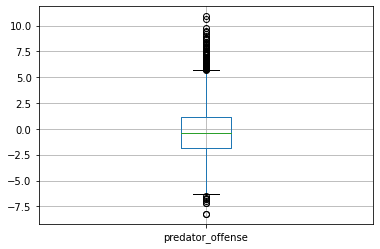

In [113]:
df.boxplot(column = 'predator_offense');

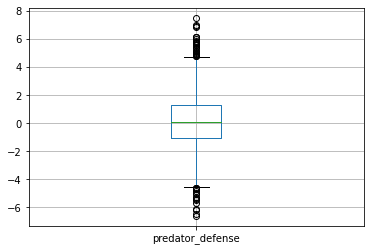

In [114]:
df.boxplot(column = 'predator_defense');

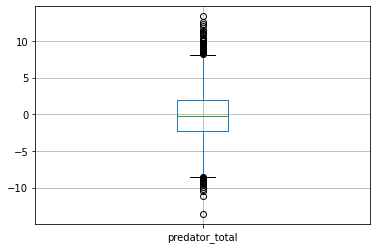

In [115]:
df.boxplot(column = 'predator_total');

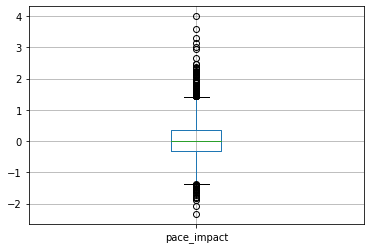

In [116]:
df.boxplot(column = 'pace_impact');

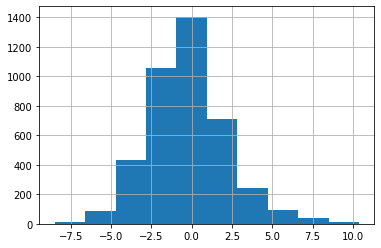

In [117]:
df['raptor_offense'].hist();

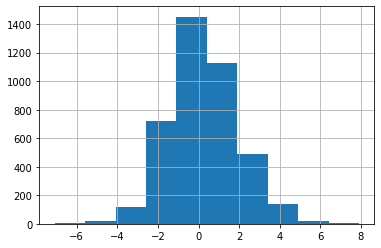

In [118]:
df['raptor_defense'].hist();

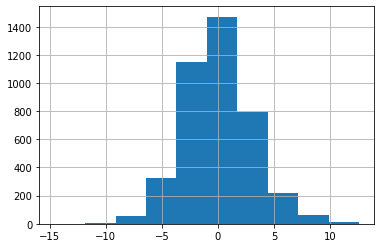

In [119]:
df['raptor_total'].hist();

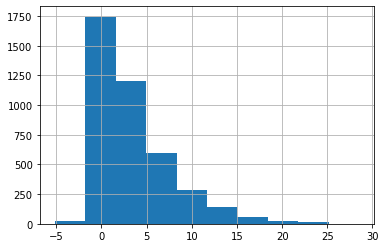

In [120]:
df['war_total'].hist();

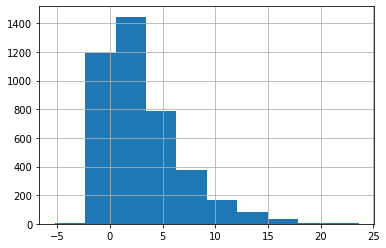

In [121]:
df['war_reg_season'].hist();

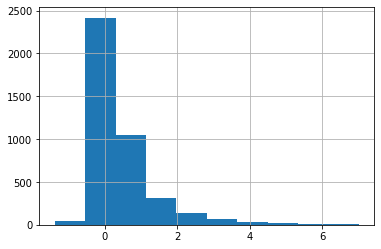

In [122]:
df['war_playoffs'].hist();

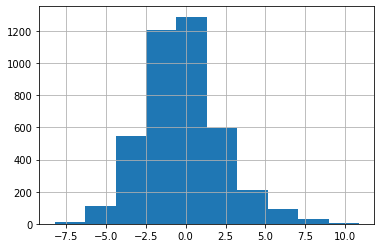

In [123]:
df['predator_offense'].hist();

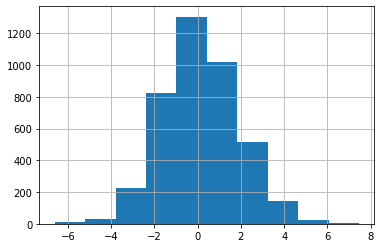

In [124]:
df['predator_defense'].hist();

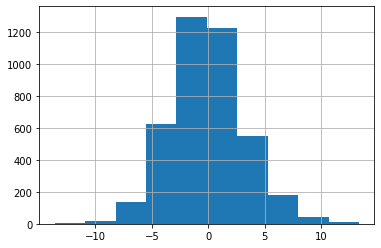

In [125]:
df['predator_total'].hist();

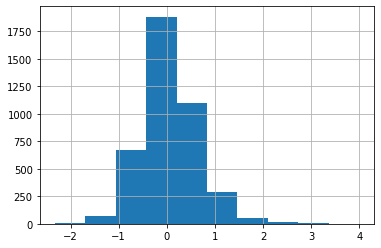

In [126]:
df['pace_impact'].hist();

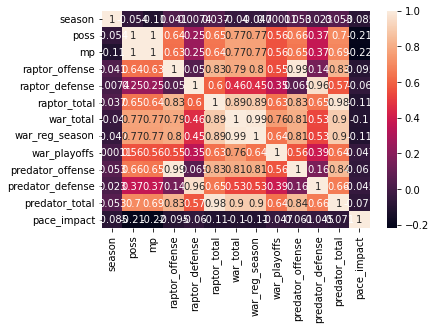

In [127]:
# Explore the relationships between variables with bivariate visuals
corr = df.corr()

sns.heatmap(corr, annot = True);

In [128]:
raptor_offense_by_year = df.groupby(['season'])['raptor_offense'].mean()

raptor_defense_by_year = df.groupby(['season'])['raptor_defense'].mean()

print(raptor_offense_by_year)

print(raptor_defense_by_year)

season
2000   -0.234995
2001   -0.433837
2002   -0.151058
2003   -0.366931
2004   -0.246055
2005   -0.337055
2006   -0.620536
2007   -0.417932
2008   -0.211027
2009   -0.420460
2010   -0.310092
2011   -0.235104
2012   -0.090267
2013   -0.301718
2014   -0.077393
2015   -0.129922
2016   -0.172491
2017   -0.310076
2018   -0.087487
2019   -0.072558
2020    0.027888
2021   -0.005428
Name: raptor_offense, dtype: float64
season
2000    0.348196
2001    0.092919
2002    0.212182
2003    0.095303
2004    0.276321
2005    0.265180
2006    0.217433
2007    0.210886
2008    0.216712
2009    0.266999
2010    0.317234
2011    0.344056
2012    0.286010
2013    0.195240
2014    0.306948
2015    0.107116
2016    0.258316
2017    0.118211
2018    0.183115
2019    0.308920
2020    0.365481
2021    0.253729
Name: raptor_defense, dtype: float64


The goal here is to just to see how the RAPTOR values(the name of 538s NBA metric) have changed on average over the past 20 yrs. Has there been a rise in offensive value measured or defensive value measured? A decrease? That is the question at hand to see league wide trends. 

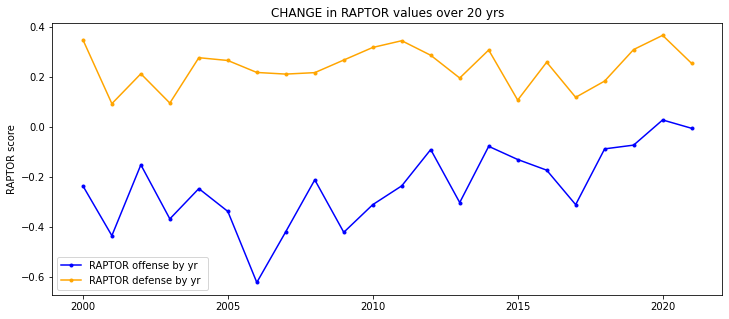

In [129]:
plt.figure(figsize = (12, 5))

plt.plot(raptor_offense_by_year.index, raptor_offense_by_year,
         color = 'blue',
         marker = '.',
         label = 'RAPTOR offense by yr')

plt.plot(raptor_defense_by_year.index, raptor_defense_by_year,
         color = 'orange',
         marker = '.',
         label = 'RAPTOR defense by yr ')

plt.legend()
plt.title('CHANGE in RAPTOR values over 20 yrs')
plt.ylabel('RAPTOR score');

We see over the past 20 yrs the model measures the average offensive value a player contributes to their team as rising by about 0.5 WAR from 2000 to 2020. The defensive value a player contributes on average has stayed the same. This isnt surprising scoring across the league has increased the past 20 years. Howevr, it's worth keeping this in mind when comparing figures across different ears. 

In [130]:
df['raptor_total'].describe

<bound method NDFrame.describe of 32      -1.169932
44       0.499564
52      -0.601411
53      -1.523468
55      -3.392775
           ...   
18533   -1.149639
18542   -3.417939
18550   -0.548676
18551    4.649308
18552    1.616696
Name: raptor_total, Length: 4094, dtype: float64>

Doing an analysis specifically of how well regular season WAR can predict playoff WAR. To do this we have to drop all the columns with 0 WAR. If a player has 0 WAR it means their team didnt make the playoffs that year. You can only do this with players who actually were able to play in the playoffs that season. 

In [131]:
df.drop(df[df.war_playoffs == 0.000000].index, inplace=True)

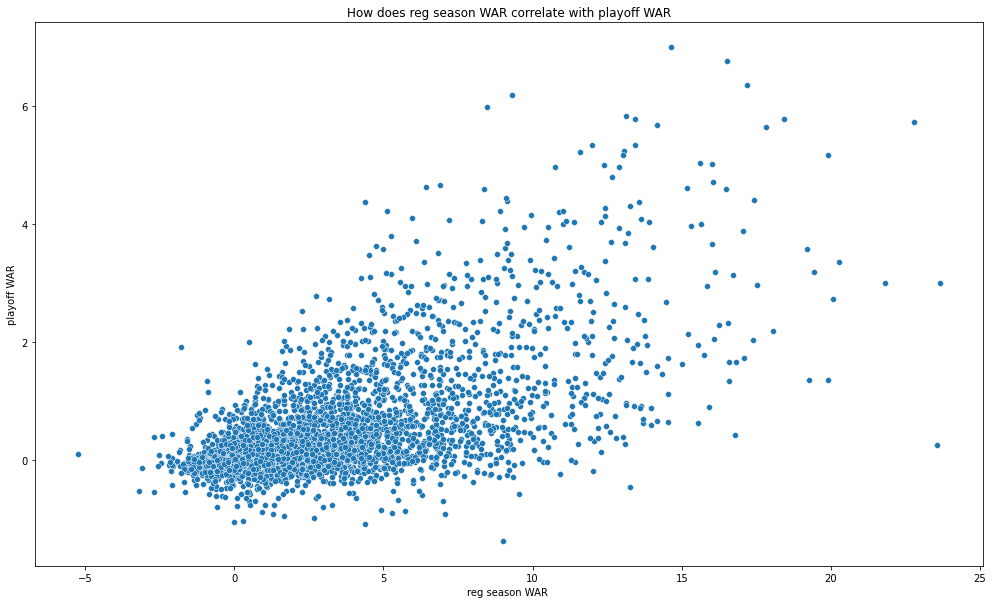

In [132]:
reg_war = df['war_reg_season']

min= ['mp']

playoff_war = df['war_playoffs']

fig = plt.gcf()

fig.set_size_inches(17, 10)

sns.scatterplot(x = reg_war, y = playoff_war, data = df)

plt.xlabel('reg season WAR ')
plt.ylabel('playoff WAR')
plt.title('How does reg season WAR correlate with playoff WAR');

In [133]:
correlation = df['war_reg_season'].corr(df['war_playoffs'])

correlation

0.6404922349222073

The goal of the following models is to delve further into the question of how well can regular season performance predict playoff performance. And the way this database measures performance in the playoffs is war_playoffs. One thing you will note earlier is I dropped the following columns: 

df.drop(df[df.mp < 250].index, inplace=True)
df.drop(df[df.season < 2000].index, inplace=True)
df.drop(df[df.war_playoffs == 0.0000000].index, inplace=True)

Note the last part of this I dropped all teh columns where playoff War = 0.000000. This is my way of dropping all columns for players who didnt make the playoffs in that particular season. So this database will only be looking at players who made the playoffs for a particular season and seeing how well the model predicted their war_playoffs compared to what their actual war_playoffs was for that season. 

We will try several different models like KNN and Random Forest. I had initially tried just making my X vector war_reg_season, however obviously just using 1 variable is not going to make a good model and the r squared of the testing data in several of the models I did using that was around 0.13. So what I decided instead was to use a number of different numerical values for X. Minutes played, 538s RAPTOR model, 538's WAR model(WAR stands for wins above replacement ie their estimate of how many wins a player contributed to his team in that season) and looked at both offense, defense and the total overall value of each player(which is a weighted average of offense and defense). 

In [134]:
# Identify target vector and features matrix
X = df.loc[:, ['mp', 'poss', 'raptor_offense', 'raptor_defense', 'raptor_total', 'war_total', 'war_reg_season']]


y = df['war_playoffs']

In [135]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [136]:
# Pre-Process for Machine Learning with a pipeline
# Dummy encode the categorical feature(s) using OneHotEncoder (this will be part of our pipeline)
# Scale the quantitative feature(s) using StandardScaler so it (this will be part of our pipeline)

# There is only one categorical feature (column) here, but it can be very helpful to define a variable for each type of feature...be careful defining features based only on dtype. If needed change the dtype to match your data.
cat_feat= make_column_selector(dtype_include = 'float64')
# This will identify all of the quantitative features (columns)
quant_feat = make_column_selector(dtype_include = 'float64')

# Instantiate the column transformers you want to use
encoder = OneHotEncoder(handle_unknown = 'ignore')
scaler = StandardScaler()

# Now make the column transformer...this matches the transformations that we want with the appropriate columns.
column_transformer = make_column_transformer((encoder, cat_feat), (scaler, quant_feat))


In [137]:
# Establish a simple baseline "model". What if all predictions were just the mean of the target? 
y_train.mean()

0.4769192696125086

In [138]:
# To evaluate the baseline model, we will use RMSE
print('Baseline Training RMSE:', np.sqrt(mean_squared_error(y_train, [y_train.mean()]*len(y_train))))
print('Baseline Testing RMSE:', np.sqrt(mean_squared_error(y_test, [y_train.mean()]*len(y_test))))

Baseline Training RMSE: 0.9007575017348687
Baseline Testing RMSE: 0.8791873562658268


In [139]:
# array.reshape(-1, 1)

In [140]:
# Try a default random forest model in the pipeline 
# Instantiate the model, notice that you can change the hyperparameters in this step. This just shows setting a random_state. 
# We will use defaults here since our hyperturning will be done with GridSearchCV
rf = RandomForestRegressor(random_state = 42)

# # Make the pipeline and include the column_transformer
rf_pipe = make_pipeline(column_transformer, rf)
# Fit only on training data!
rf_pipe.fit(X_train, y_train)

# # Obtain evaluation metrics on both train and test sets
print('RF Training RMSE:', np.sqrt(mean_squared_error(y_train, rf_pipe.predict(X_train))))
print('RF Testing RMSE:', np.sqrt(mean_squared_error(y_test, rf_pipe.predict(X_test))))
print('------')
print('RF Training R2:', r2_score(y_train, rf_pipe.predict(X_train)))
print('RF Testing R2:', r2_score(y_test, rf_pipe.predict(X_test)))

RF Training RMSE: 0.07826732650553402
RF Testing RMSE: 0.2017195112835597
------
RF Training R2: 0.9924500300512565
RF Testing R2: 0.9473516518323757


In [141]:
# Try a default KNN model in the pipeline 
# Instantiate the model
knn = KNeighborsRegressor()

# Make the pipeline...notice we included the column_transformer here
knn_pipe = make_pipeline(column_transformer, knn)

# Fit on training data only
knn_pipe.fit(X_train, y_train)

# Obtain evaluation metrics on both the train and test sets. 
# Be sure to use metrics appropriate for they type of problem (regression metrics for regression or classification metrics for classification)

print('KNN Training RMSE:', np.sqrt(mean_squared_error(y_train, knn_pipe.predict(X_train))))
print('KNN Testing RMSE:', np.sqrt(mean_squared_error(y_test, knn_pipe.predict(X_test))))
print('------')
print('KNN Training R2:', r2_score(y_train, knn_pipe.predict(X_train)))
print('KNN Testing R2:', r2_score(y_test, knn_pipe.predict(X_test)))

KNN Training RMSE: 0.36125633903831056
KNN Testing RMSE: 0.43343144969297986
------
KNN Training R2: 0.8391521806229068
KNN Testing R2: 0.7569308870398467


In [142]:
# Hypertuning KNN

knn_pipe.get_params()

{'columntransformer': ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
                   transformer_weights=None,
                   transformers=[('onehotencoder',
                                  OneHotEncoder(categories='auto', drop=None,
                                                dtype=<class 'numpy.float64'>,
                                                handle_unknown='ignore',
                                                sparse=True),
                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f408c08a6d0>),
                                 ('standardscaler',
                                  StandardScaler(copy=True, with_mean=True,
                                                 with_std=True),
                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f408c08af90>)],
                   verbose=False),
 'columntransformer__n_jobs': None,
 'columntransf

In [143]:
# Define the hyperparameters you want to test.
knn_params = {'kneighborsregressor__n_neighbors' : [5, 7, 9],
              'kneighborsregressor__leaf_size' : [15, 20, 25]}
              

In [144]:
# Instantiate the Gridsearch with the KNN pipeline and the knn_params 
knn_gs1 = GridSearchCV(knn_pipe, knn_params)

knn_gs1.fit(X_train, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('columntransformer',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(categories='auto',
                                                                                       drop=None,
                                                                                       dtype=<class 'numpy.float64'>,
                                                                                       handle_unknown='ignore',
                    

In [145]:

knn_gs1.best_params_

{'kneighborsregressor__leaf_size': 15, 'kneighborsregressor__n_neighbors': 5}

In [146]:
print('KNN_GS Training RMSE:', np.sqrt(mean_squared_error(y_train, knn_gs1.predict(X_train))))
print('KNN_GS Testing RMSE:', np.sqrt(mean_squared_error(y_test, knn_gs1.predict(X_test))))
print('------')
print('KNN_GS Training R2:', r2_score(y_train, knn_gs1.predict(X_train)))
print('KNN_GS Testing R2:', r2_score(y_test, knn_gs1.predict(X_test)))

KNN_GS Training RMSE: 0.36125633903831056
KNN_GS Testing RMSE: 0.43343144969297986
------
KNN_GS Training R2: 0.8391521806229068
KNN_GS Testing R2: 0.7569308870398467


Conclusion: The random forest model appears to have a higher r squared value and a lower RMSE so between the two it may perhaps be the better of the models. However, I also need to continue to analyze and look closer at hte data to see logically which of the models we have used so far in our course will make the most sense practically in terms of the data Im using over the last two weeks of the project so by no means is this the only model I would definitively choose to put "in production" per se.

In [147]:
df1 = df1[df1['P/36'].notna()]
df1 = df1[df1['A/36'].notna()]
df1 = df1[df1['R/36'].notna()]
df1 = df1[df1['SB/36'].notna()]
df1 = df1[df1['TO/36'].notna()]
df1 = df1[df1['%Pos'].notna()]
df1 = df1[df1['2P%'].notna()]
df1 = df1[df1['3P%'].notna()]



In [148]:
df1

,player_id,name_common,year_id,type,age,team_id,pos,tmRtg,franch_id,G,Min,MP%,MPG,P/36,TS%,A/36,R/36,SB/36,TO/36,Raptor O,Raptor D,Raptor+/-,Raptor WAR,PIE%,AWS%,USG%,AST%,TOV%,ORB%,DRB%,TRB%,STL%,BLK%,ORtg,%Pos,DRtg,2P%,3P%,FT%,3PAr,FTAr,Pace +/-
808,youngtr01,Trae Young,2019,RS,20,ATL,1,-5.7,ATL,81,2503,63.0,30.9,21.4,53.9,9.0,4.2,1.2,4.3,2.4,-4.5,-2.1,0.82,12.5,10.2,28.4,40.5,17.6,2.6,10.2,6.3,1.3,0.5,107.4,29.8,116.8,47.7,32.4,82.9,38.4,33.0,1.8
809,huertke01,Kevin Huerter,2019,RS,20,ATL,2,-5.7,ATL,75,2048,51.6,27.3,12.3,53.3,3.6,4.1,1.5,1.8,0.4,-2.2,-1.8,1.04,6.7,6.9,15.7,14.5,13.8,3.0,9.7,6.3,1.5,1.1,105.5,15.7,116.2,45.7,38.5,73.2,53.7,8.5,0.6
810,bembrde01,DeAndre' Bembry,2019,RS,24,ATL,2,-5.7,ATL,82,1931,48.6,23.5,12.3,50.8,3.6,6.4,2.6,2.5,-3.2,1.1,-2.1,0.66,7.8,6.6,17.2,14.7,17.4,2.9,16.9,9.7,2.5,1.8,97.2,17.4,111.5,50.8,28.9,64.0,28.1,22.1,0.6
811,collijo01,John Collins,2019,RS,21,ATL,4,-5.7,ATL,61,1829,46.1,30.0,22.5,62.7,2.3,11.3,1.2,2.3,3.2,-0.5,2.7,5.13,14.3,14.9,23.7,11.0,11.2,12.3,22.1,17.1,0.6,1.8,121.7,23.3,114.6,60.9,34.8,76.3,19.0,32.0,0.2
812,bazemke01,Kent Bazemore,2019,RS,29,ATL,2,-5.7,ATL,67,1643,41.4,24.5,16.4,50.7,3.2,5.5,2.8,2.6,-2.9,0.6,-2.3,0.39,7.8,6.9,22.0,13.5,13.6,2.3,14.6,8.3,2.5,2.2,98.1,21.3,111.8,46.5,32.0,72.6,43.4,25.3,1.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15257,hamilri01,Richard Hamilton,2000,RS,21,WAS,2,-3.5,WAS,71,1373,34.7,19.3,18.1,48.2,3.1,3.6,1.0,2.4,-1.5,-2.6,-4.1,-0.97,6.6,3.7,24.2,13.7,11.2,3.1,7.7,5.4,1.1,0.3,97.9,22.8,110.8,42.8,36.4,77.4,12.7,22.0,0.2
15258,austiis01,Isaac Austin,2000,RS,30,WAS,5,-3.5,WAS,59,1173,29.6,19.9,13.1,48.1,2.4,9.3,1.8,3.5,-5.2,-1.3,-6.5,-2.26,7.7,4.0,19.6,10.0,20.6,6.2,21.7,13.8,0.8,2.3,89.4,19.8,105.9,43.1,25.0,68.6,1.1,38.9,0.0
15259,smithmi02,Michael Smith,2000,RS,27,WAS,3,-3.5,WAS,46,1145,28.9,24.9,9.8,61.1,1.9,11.2,1.7,1.5,1.5,-0.1,1.4,2.42,10.5,13.3,10.9,7.3,16.0,12.0,21.4,16.6,1.2,1.4,122.6,12.1,105.6,56.5,0.0,72.3,0.5,52.6,-0.4
15260,kingge02,Gerard King,2000,RS,27,WAS,3,-3.5,WAS,62,1060,26.8,17.1,12.0,53.4,1.8,9.2,1.8,1.5,-0.2,-0.1,-0.2,1.36,9.1,10.1,14.5,7.4,11.8,9.0,18.2,13.6,1.7,1.0,110.5,14.6,105.9,50.2,0.0,74.2,0.0,23.8,0.0


Something else I wanted to look at: Are there clear trends in the data amongst players at different positions? Do for example centers contribute more value in areas like defense and do they contribute more to winning(as measured per 538s WAR--wins above replacement model). Do guards tend to contribute more to winning? Are there clusters of data that tend to be common amongst guards vs bigger players? That's the goal of this cluster analysis is to just identify trends that might otherwise not be obvious. 


 We'll include a few other common metrics like steals+ blocks per 36 min and points per 36 min to help create a better model for clustering. 

In [149]:
X = df1.loc[:, ['SB/36', 'P/36', 'Raptor O', 'Raptor D', 'Raptor WAR', 'Pace +/-', 'pos']]



In [150]:
# scale the data
scaler = StandardScaler()




scaled_x = scaler.fit_transform(X)


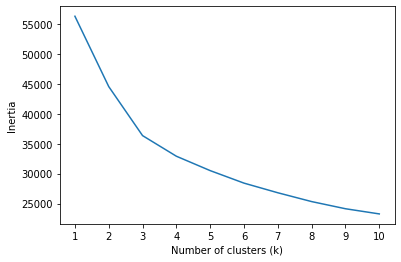

In [151]:
# define a range of values of k to evaulate for intertia score, fit and run the model, and plot the results
ks = range(1, 11)
inertias = []

for k in ks:
    model = KMeans(n_clusters = k)
    model.fit(scaled_x)
    inertias.append(model.inertia_)

plt.plot(ks, inertias)
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.xticks(ks)
plt.show()

In [152]:
# instantiate a Kmeans model with the value for k based on elbow plot method and silhouette score

km = KMeans(n_clusters = 3, random_state = 42)

# add a column to the dataframe to add the cluster lable as you fit and predict x 
df1['clusters'] =km.fit_predict(scaled_x)

# adding cluster info to data frame can use that as another variable in your datafrmae to be able to group by diff things 

In [153]:
# examine your dataframe with .head()
df1.head(5)

,player_id,name_common,year_id,type,age,team_id,pos,tmRtg,franch_id,G,Min,MP%,MPG,P/36,TS%,A/36,R/36,SB/36,TO/36,Raptor O,Raptor D,Raptor+/-,Raptor WAR,PIE%,AWS%,USG%,AST%,TOV%,ORB%,DRB%,TRB%,STL%,BLK%,ORtg,%Pos,DRtg,2P%,3P%,FT%,3PAr,FTAr,Pace +/-,clusters
808,youngtr01,Trae Young,2019,RS,20,ATL,1,-5.7,ATL,81,2503,63.0,30.9,21.4,53.9,9.0,4.2,1.2,4.3,2.4,-4.5,-2.1,0.82,12.5,10.2,28.4,40.5,17.6,2.6,10.2,6.3,1.3,0.5,107.4,29.8,116.8,47.7,32.4,82.9,38.4,33.0,1.8,1
809,huertke01,Kevin Huerter,2019,RS,20,ATL,2,-5.7,ATL,75,2048,51.6,27.3,12.3,53.3,3.6,4.1,1.5,1.8,0.4,-2.2,-1.8,1.04,6.7,6.9,15.7,14.5,13.8,3.0,9.7,6.3,1.5,1.1,105.5,15.7,116.2,45.7,38.5,73.2,53.7,8.5,0.6,1
810,bembrde01,DeAndre' Bembry,2019,RS,24,ATL,2,-5.7,ATL,82,1931,48.6,23.5,12.3,50.8,3.6,6.4,2.6,2.5,-3.2,1.1,-2.1,0.66,7.8,6.6,17.2,14.7,17.4,2.9,16.9,9.7,2.5,1.8,97.2,17.4,111.5,50.8,28.9,64.0,28.1,22.1,0.6,2
811,collijo01,John Collins,2019,RS,21,ATL,4,-5.7,ATL,61,1829,46.1,30.0,22.5,62.7,2.3,11.3,1.2,2.3,3.2,-0.5,2.7,5.13,14.3,14.9,23.7,11.0,11.2,12.3,22.1,17.1,0.6,1.8,121.7,23.3,114.6,60.9,34.8,76.3,19.0,32.0,0.2,0
812,bazemke01,Kent Bazemore,2019,RS,29,ATL,2,-5.7,ATL,67,1643,41.4,24.5,16.4,50.7,3.2,5.5,2.8,2.6,-2.9,0.6,-2.3,0.39,7.8,6.9,22.0,13.5,13.6,2.3,14.6,8.3,2.5,2.2,98.1,21.3,111.8,46.5,32.0,72.6,43.4,25.3,1.6,2


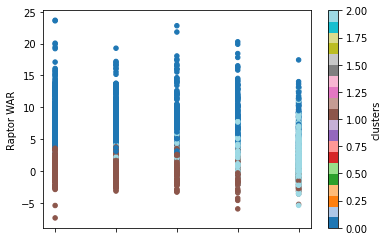

In [154]:
# Make a scatterplot with these features and color code it based on the cluster.
df1.plot(kind = 'scatter', x = 'pos', y = 'Raptor WAR', c = 'clusters', cmap = 'tab20')

You can see hte graph for yourself above. There arent real meaningful trends across the 5 positions when talking about value added per 538s RAPTOR WAR model. 

Now look below. Another thing I wanted to plot is unofficially for many decades fans have used points as the main gauge of players value. 538 has their new model called RAPTOR. So i wanted to directly look at the newer 538 model vs the "older more unofficial way" of evaluating players. Are there clear trends and clusters, in other words to players who tend to score a certain range of points tend to have relatively similar RAPTOR WAR values? Of course the model also has other variables that help influence this but I still thought it would be interesting if there were clear clusters. And it turns out we do have a few. 

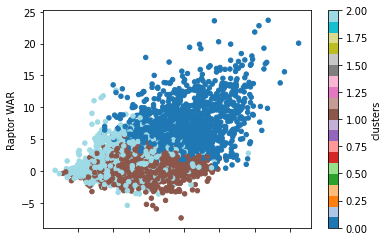

In [155]:
# Make a scatterplot with these features and color code it based on the cluster.
df1.plot(kind = 'scatter', x = 'P/36', y = 'Raptor WAR', c = 'clusters', cmap = 'tab20')

Now we look at one more question: does player data help predict what position they play? There are a few reasons why this is of interest to me. One thing is you will commonly here people debate what position a player is. "Is he a true point guard" vs "Is he a true center" vs "this guy is positionless he does everything dont define him to one position" etc. So then it bears asking, can we predict what position a player most likely is based on certain statistical barometers? Is it really true that point guards will have alot more assists than shooting guards, ie if a player is not a good passer does that mean we should be more hesitant in considering him a point guard? 

If you score alot and turn the ball over alot, does that for example help predict you are more likely to be one position than another? I just think being able to define and predict positions and characteristics of players at those positions is important. We're gonna do logistic regression here for this. 

There will be two logistic models. One is just incorporating traditional box score tracking data points, assists, rebounds, steals, turnovers etc. The other will incorporate those and 538s RAPTOR model. So the purpose of that is to see does 538's model which measures performance help us improving our predictions of what position a player is? Some hypotheticals to help think about why we might do this. For example you might have a player who puts up very good traditional stats, tons of points, tons of assists etc. But the advanced 538 RAPTOR model doesnt rate him so highly. Perhaps his gaudy stat line isnt as impressive as it might actually seem? Knowing this, can it help us predict positional characteristics? Are guys like this more likely to be point guards vs power fowards vs small forwards etc? 

In [172]:
X1 = df1.loc[:, ['age', 'P/36', 'A/36', 'R/36', 'SB/36', '3P%', 'TO/36', 'FTAr']]

y1 = df1['pos']

In [160]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

In [169]:
X_train, X_test, y_train, y_test =train_test_split(X,
                                                   y,
                                                   test_size=0.3, 
                                                   random_state=0, 
                                                   stratify=y)

In [170]:
# Standardize Data
scaler = StandardScaler()
# Fit on training set only.
scaler.fit(X_train)
# Apply transform to both the training set and the test set.
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# generally always scale our data for logistic regression

In [163]:
# logistic regression - one v one
from sklearn.multiclass import OneVsOneClassifier

log_reg = LogisticRegression()
# estimator we want to classify


ovo = OneVsOneClassifier(log_reg)
ovo.fit(X_train, y_train)

print('Training accuracy:', ovo.score(X_train, y_train))
print('Test accuracy:', ovo.score(X_test, y_test))

Training accuracy: 0.6523978685612789
Test accuracy: 0.6585163696643183


Logistic Regression One vs All

In [164]:
log_reg = LogisticRegression(multi_class = 'ovr')
log_reg.fit(X_train, y_train)

print('Training accuracy:', log_reg.score(X_train, y_train))
print('Test accuracy:', log_reg.score(X_test, y_test))

Training accuracy: 0.633392539964476
Test accuracy: 0.6311645254869457


Logistic Regression using L1 and L2 

In [165]:
# First will try using L1

log_reg = LogisticRegression(penalty = 'l1', solver = 'liblinear')
# need liblinear solver in order for L1 to work

log_reg.fit(X_train, y_train)

print('Training accuracy:', log_reg.score(X_train, y_train))
print('Test accuracy:', log_reg.score(X_test, y_test))

# logistic regression - l2
log_reg = LogisticRegression(penalty = 'l2')
log_reg.fit(X_train, y_train)

print('Training accuracy:', log_reg.score(X_train, y_train))
print('Test accuracy:', log_reg.score(X_test, y_test))

Training accuracy: 0.6330373001776199
Test accuracy: 0.6299212598425197
Training accuracy: 0.647246891651865
Test accuracy: 0.6585163696643183


In [166]:
log_reg.coef_

array([[-0.54075567, -0.29741667,  2.99312242, -3.97351412, -0.048396  ,
         0.02280295, -0.01308427, -0.08679376, -0.25784791],
       [-0.29106956, -0.0447304 ,  0.06984729, -2.61595613, -0.1996583 ,
         0.5623689 , -0.13949561,  0.19309856, -0.01380243],
       [-0.00450009, -0.16034778, -1.02070706,  0.0735692 , -0.20240768,
         0.46833238,  0.23468969,  0.2716147 ,  0.04650937],
       [ 0.31164135,  0.23707152, -0.94981185,  2.87027806, -0.09033251,
        -0.30358046,  0.07953206, -0.19305052, -0.00449049],
       [ 0.52468397,  0.26542333, -1.0924508 ,  3.64562298,  0.54079449,
        -0.74992378, -0.16164187, -0.18486898,  0.22963146]])

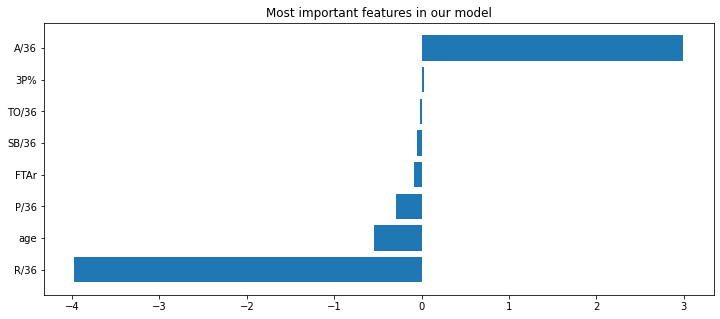

In [173]:
coef = pd.DataFrame(zip(X1.columns, log_reg.coef_[0]), columns = ['Class label', 'Coef'])
coef.sort_values(by='Coef', inplace= True)

plt.figure(figsize =(12, 5))
plt.barh(coef['Class label'], coef['Coef'])
plt.title('Most important features in our model');

The model shows that what drives position predictions are your rebounding and assist figures above all else. This is interesting. More rebounding means you are more likely to be a powerforward or center. And more assists means you are more likely to be a guard. Not shocking per se. What is interesting is the degree to which it is of much greater significance than any other variable. Assists and turnovers are often related to each other, cant have alot of assists and helping out teammates without turning it over some also sometimes. And yet turnover rate(TO) seems to matter very little when prediction positions. Another interesting takeaway; the 3 pointer is gaining in popularity each year in the NBA. Guards tend to be the most dangerous 3 point shooters. and yet, 3 point % has very little influence in our model on prediction position despite its importance in the game. 

Now below we can do our 2nd model one that incorporates the 538 data. 

In [184]:
X2 = df1.loc[:, ['age', 'P/36', 'A/36', 'R/36', 'SB/36', 'Raptor+/-', '3P%', 'TO/36', 'FTAr', 'Raptor O', 'Raptor D', 'Raptor WAR']]

y2 = df1['pos']


In [185]:
X_train, X_test, y_train, y_test =train_test_split(X,
                                                   y,
                                                   test_size=0.3, 
                                                   random_state=0, 
                                                   stratify=y)

In [177]:
# Standardize Data
scaler = StandardScaler()
# Fit on training set only.
scaler.fit(X_train)
# Apply transform to both the training set and the test set.
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# generally always scale our data for logistic regression

In [ ]:
# logistic regression - one v one
from sklearn.multiclass import OneVsOneClassifier

log_reg = LogisticRegression()
# estimator we want to classify


ovo = OneVsOneClassifier(log_reg)
ovo.fit(X_train, y_train)

print('Training accuracy:', ovo.score(X_train, y_train))
print('Test accuracy:', ovo.score(X_test, y_test))

logistic regression one vs all

In [187]:
log_reg = LogisticRegression(multi_class = 'ovr')
log_reg.fit(X_train, y_train)

print('Training accuracy:', log_reg.score(X_train, y_train))
print('Test accuracy:', log_reg.score(X_test, y_test))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Training accuracy: 0.6319715808170515
Test accuracy: 0.630335681723995


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [180]:
# First will try using L1

log_reg = LogisticRegression(penalty = 'l1', solver = 'liblinear')
# need liblinear solver in order for L1 to work

log_reg.fit(X_train, y_train)

print('Training accuracy:', log_reg.score(X_train, y_train))
print('Test accuracy:', log_reg.score(X_test, y_test))

# logistic regression - l2
log_reg = LogisticRegression(penalty = 'l2')
log_reg.fit(X_train, y_train)

print('Training accuracy:', log_reg.score(X_train, y_train))
print('Test accuracy:', log_reg.score(X_test, y_test))

Training accuracy: 0.6330373001776199
Test accuracy: 0.6299212598425197
Training accuracy: 0.647246891651865
Test accuracy: 0.6585163696643183


In [181]:
log_reg.coef_

array([[-0.54075567, -0.29741667,  2.99312242, -3.97351412, -0.048396  ,
         0.02280295, -0.01308427, -0.08679376, -0.25784791],
       [-0.29106956, -0.0447304 ,  0.06984729, -2.61595613, -0.1996583 ,
         0.5623689 , -0.13949561,  0.19309856, -0.01380243],
       [-0.00450009, -0.16034778, -1.02070706,  0.0735692 , -0.20240768,
         0.46833238,  0.23468969,  0.2716147 ,  0.04650937],
       [ 0.31164135,  0.23707152, -0.94981185,  2.87027806, -0.09033251,
        -0.30358046,  0.07953206, -0.19305052, -0.00449049],
       [ 0.52468397,  0.26542333, -1.0924508 ,  3.64562298,  0.54079449,
        -0.74992378, -0.16164187, -0.18486898,  0.22963146]])

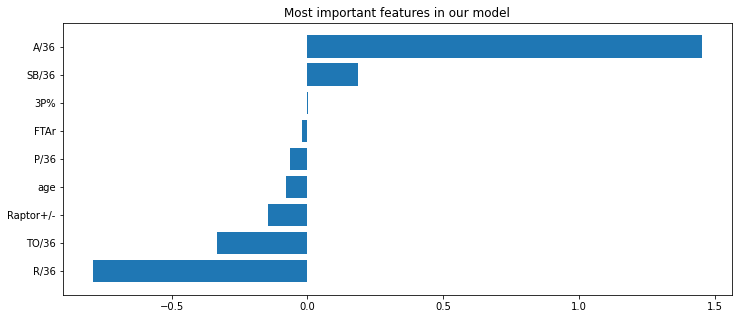

In [188]:
coef = pd.DataFrame(zip(X2.columns, log_reg.coef_[0]), columns = ['Class label', 'Coef'])
coef.sort_values(by='Coef', inplace= True)

plt.figure(figsize =(12, 5))
plt.barh(coef['Class label'], coef['Coef'])
plt.title('Most important features in our model');